In [1]:
from dotenv import load_dotenv, find_dotenv
import os 
from langgraph.prebuilt import create_react_agent
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.chains import ConversationalRetrievalChain,load_summarize_chain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.document_loaders import UnstructuredExcelLoader,PyPDFLoader
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
import lmstudio as lms
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.messages import convert_to_messages

load_dotenv(find_dotenv(), override=True)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

llm_openai = ChatOpenAI(model="gpt-4-turbo-2024-04-09",temperature=0.1)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')

career_trends_store = Chroma(
    collection_name="career_trends",
    embedding_function=embeddings,
    persist_directory="./career_trends_db",
)

upskilling_training_store = Chroma(
    collection_name="upskilling_training",
    embedding_function=embeddings,
    persist_directory="./upskilling_training_db",
)

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

/var/folders/66/z_b55kvs5xxbskrymwm96gm00000gn/T/ipykernel_47904/673463658.py:22: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')


In [2]:
def career_readiness_evaluation(emirates_id: str):
    """
    Analyzes the applicant's resume and evaluates career alignment with current UAE job market
    using the career trends vector store. Extracts in-demand skills, matches booming roles,
    and estimates rehire potential based on hiring demand and skill match.
    """
    resume_file_path = f"resumes/{emirates_id}.pdf"
    loader = PyPDFLoader(resume_file_path)
    docs = loader.load_and_split()

    chain = load_summarize_chain(llm_openai, chain_type="stuff", verbose=False)
    summary = chain.invoke(docs)
    final_summary = summary['output_text']

    query = f"""
    You are a Career Readiness Agent for the UAE job market.

    Given the following summarized resume content, assess the following:
    - Match the applicant's experience and skills against booming job roles in the UAE
    - Identify in-demand tools and skills found in the resume
    - Predict short-term rehire potential (High, Moderate, Low) based on hiring demand
    - Output the estimated employment gap in months as an integer
    - Return a structured response in JSON with keys:
        - "employment_gap_months"
        - "career_alignment_score" (0 to 1)
        - "in_demand_skills_matched" (list of matched tools/skills)
        - "rehire_potential" (High, Moderate, or Low)

    Resume Summary:
    {final_summary}
    """

    retriever = career_trends_store.as_retriever(
        search_type="mmr", search_kwargs={"k": 1, "fetch_k": 2}
    )

    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm_openai, retriever=retriever, memory=memory, verbose=False
    )

    return conversational_retrieval.invoke(query)["answer"]

career_readiness_agent = create_react_agent(
    model=llm_openai,
    tools=[career_readiness_evaluation],
    prompt=(
        "You are a Career Readiness Evaluation Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your job is to evaluate the applicant's employability and job market alignment based on their resume.\n"
        "- Use the available tool to analyze the resume and match it against current UAE job market trends and skill demands.\n"
        "- Extract any in-demand tools or roles that match the applicant's background using semantic search.\n"
        "- Assess the likelihood of short-term rehire based on current hiring activity in UAE.\n"
        "- DO NOT explain your reasoning or provide extra commentary.\n"
        "- Return only the following structured JSON:\n\n"
        "  employment_gap_months: <integer>,\n"
        "  career_alignment_score: <float between 0 and 1>,\n"
        "  in_demand_skills_matched: [\"skill_1\", \"skill_2\"],\n"
        "  rehire_potential: \"High\" | \"Moderate\" | \"Low\"\n"
    ),
    name="career_readiness_agent"
)

In [3]:
def upskilling_program_matcher(emirates_id: str):
    """
    Matches the applicant's current domain, skill gaps, and career readiness with available
    upskilling and training programs using the upskilling vector store. Returns personalized
    program recommendations for training or career pivoting.
    """
    resume_file_path = f"resumes/{emirates_id}.pdf"
    loader = PyPDFLoader(resume_file_path)
    docs = loader.load_and_split()

    chain = load_summarize_chain(llm_openai, chain_type="stuff", verbose=False)
    summary = chain.invoke(docs)
    final_summary = summary['output_text']

    query = f"""
    You are an Upskilling Program Matching Agent.

    Given the resume summary and the applicant profile below, identify suitable upskilling
    and job placement programs for this applicant from the vector store:

    Resume Summary:
    {final_summary}
      
    """

    retriever = upskilling_training_store.as_retriever(
        search_type="mmr", search_kwargs={"k": 2, "fetch_k": 4}
    )

    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm_openai, retriever=retriever, memory=memory, verbose=False
    )

    return conversational_retrieval.invoke(query)["answer"]

upskilling_program_agent = create_react_agent(
    model=llm_openai,
    tools=[upskilling_program_matcher],
    prompt=(
        "You are an Upskilling Program Recommendation Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Use the provided resume and applicant data to recommend relevant upskilling, training,\n"
        "  or career transition programs.\n"
        "- Use vector search to match programs that align with current domain or open opportunities.\n"
        "- Focus on programs that are practical, accessible, and improve short-term employability.\n"
        "- Match programs that help improve employability, fill current domain skill gaps,\n"
        "  and offer job transition support if relevant.\n\n"
        "- Return a structured response in JSON with keys:\n"
        "    - \"employment_gap_months\"\n"
        "    - \"career_alignment_score\" (0 to 1)\n"
        "    - \"in_demand_skills_matched\" (list of matched tools/skills)\n"
        "    - \"rehire_potential\" (High, Moderate, or Low)\n"
        "    - \"recommended_course_topics\": [\"Topic A\", \"Topic B\"]"
    ),
    name="upskilling_program_agent"
)


In [4]:
enablement_planner_supervisor = create_supervisor(
    model=llm_openai,
    agents=[career_readiness_agent, upskilling_program_agent],
    prompt=(
        "You are the Enablement Planning Supervisor.\n"
        "You must invoke BOTH of the following agents and combine their outputs:\n"
        "- career_readiness_agent: evaluates career alignment and rehire potential using resume data.\n"
        "- upskilling_program_agent: recommends upskilling or career transition programs using the applicant metadata.\n\n"
        "After invoking both agents:\n"
        "- Extract all attributes from their JSON responses.\n"
        "- Construct and return a unified response in natural language which will be the final response to the "
        "applicant resulting from having considered the below key factors from both agents:\n"
        "    - employment_gap_months\n"
        "    - career_alignment_score\n"
        "    - in_demand_skills_matched\n"
        "    - rehire_potential\n"
        "    - recommended_course_topics (from upskilling_program_agent)\n\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()


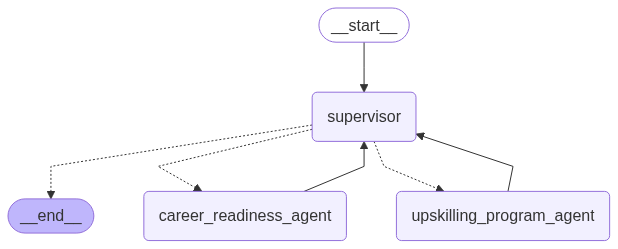

In [5]:
from IPython.display import display, Image

display(Image(enablement_planner_supervisor.get_graph().draw_mermaid_png()))

In [6]:
emirates_id = "1234"
applicant_data = {
    "CurrentlyEmployed": "No",
    "last_drawn_salary": "12000 AED",
    "last_employment_date": "05-10-2024",
    "current_work_domain": "IT/Data analyst"
}

query = f"""
Evaluate the career readiness and upskilling plan of the applicant using their resume associated with Emirates ID: {emirates_id} and the applicant metadata below:
{applicant_data}
"""

response = enablement_planner_supervisor.invoke(
    {
        "messages": [
            {"role": "user", "content": query}
        ]
    },
    {"recursion_limit": 10}
)

history = response["messages"]  

last_msg = history[-1]  
if hasattr(last_msg, "content"):
    final = last_msg.content
else:
    final = last_msg["content"]

print(final)

Currently, there is an issue with accessing the resume file for Emirates ID: 1234. The file path provided is not valid or the file is not accessible. Please ensure the file path is correct and the file is available for processing to proceed with the evaluation and recommendation.
